<a href="https://colab.research.google.com/github/nichakornchaisuwan/Project_Boneage/blob/main/BoneAgePredictor_NObatchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
from PIL import Image

In [4]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def dataset_path(*rel_path):
    return os.path.join('/content/drive/My Drive/Project_Boneage', *rel_path);

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
class BoneAgeTrainingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double(),\
               torch.from_numpy(male).double()

In [8]:
class BoneAgeValidationDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double(),\
               torch.from_numpy(male).double()

In [9]:
class BoneAgeTestingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [10]:
class BoneAgePredictor(nn.Module):
    def __init__(self):
        super(BoneAgePredictor, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 32, 3)
        nn.init.kaiming_normal_(self.conv1.weight)
        #self.batch1 = nn.BatchNorm2d(32)
        # Layer 2
        self.conv2 = nn.Conv2d(32, 64, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        #self.batch2 = nn.BatchNorm2d(64)
        # Layer 3
        self.conv3 = nn.Conv2d(64, 128, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        #self.batch3 = nn.BatchNorm2d(128)
        # Layer 4
        self.conv4 = nn.Conv2d(128, 256, 3)
        nn.init.kaiming_normal_(self.conv4.weight)
        #self.batch4 = nn.BatchNorm2d(256)
        # Layer 5
        self.conv5 = nn.Conv2d(256, 512, 3)
        nn.init.kaiming_normal_(self.conv5.weight)
        #self.batch5 = nn.BatchNorm2d(512)
        # Fully connected
        self.fc1 = nn.Linear(18433, 136)
        self.fc2 = nn.Linear(137, 1)
        #self.fc2 = nn.Linear(64, 1)
    
        

    def forward(self, x, m):
        # Layer 1
        x = F.relu((self.conv1(x)))
        x = F.max_pool2d(x, 2)
        # Layer 2
        x = F.relu((self.conv2(x)))
        x = F.max_pool2d(x, 2)
        # Layer 3
        x = F.relu((self.conv3(x)))
        x = F.max_pool2d(x, 2)
        # Layer 4
        x = F.relu((self.conv4(x)))
        x = F.max_pool2d(x, 2)
        # Layer 5
        x = F.relu((self.conv5(x)))
        x = F.max_pool2d(x, 2)
        
        # Pooling
        x = x.view(-1,18432)
        x = torch.cat((x,m), axis = 1)
        x = self.fc1(x)
        x = torch.cat((x,m), axis = 1)
        x = self.fc2(x)
        #x = torch.cat((x,m), axis = 1)
        #x = self.fc3(x)
        return x

In [11]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target, male) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, male)
        loss = F.l1_loss(output.view(-1), target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [12]:
def validation(model, device, val_loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(val_loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;
     

In [13]:
def test(model, device, loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cpu" if use_cuda else "gpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
trainig_data_loader = torch.utils.data.DataLoader(
    BoneAgeTrainingDataset('train_z.csv', 'boneage_training_dataset'),
    batch_size=64, shuffle=True, **kwargs)
validation_data_loader = torch.utils.data.DataLoader(
    BoneAgeValidationDataset('validation_z.csv', 'boneage_validation_dataset'),
    batch_size=64, shuffle=True, **kwargs)
testing_data_loader = torch.utils.data.DataLoader(
    BoneAgeTestingDataset('boneage-test-dataset.csv', 'boneage-test-dataset'),
    batch_size=64, shuffle=True, **kwargs)

In [15]:
device

device(type='cpu')

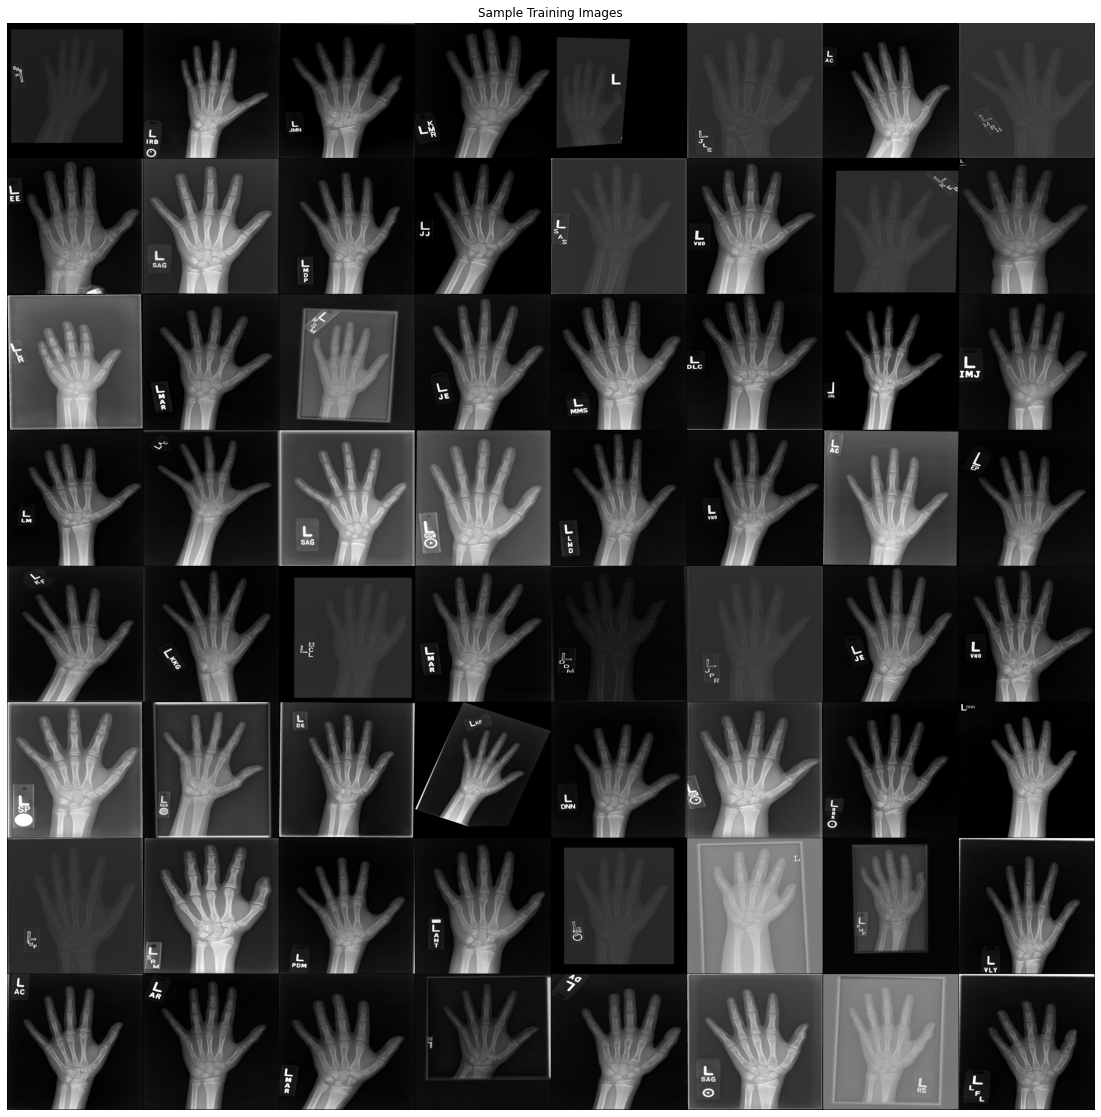

In [16]:
# Plot samples
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

sample_batch = next(iter(trainig_data_loader))
plt.figure(figsize=(20, 20)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

In [17]:
model = BoneAgePredictor().double().to(device)
print(model)
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=1e-3, verbose=True)

BoneAgePredictor(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=18433, out_features=136, bias=True)
  (fc2): Linear(in_features=137, out_features=1, bias=True)
)


In [18]:
train_losses = []
val_losses = []
for epoch in range(10):
        train(model, device, trainig_data_loader, optimizer, epoch)
        train_loss = validation(model, device, trainig_data_loader,'Train')
        val_loss = validation(model, device, validation_data_loader,'Validation')
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        checkpoint = torch.save({
            'epoch': epoch + 1,
            'train_loss': train_losses,
            'val_loss': val_losses,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        },'model_checkpoint.npy')

Train Epoch: 0 [0/10089 (0%)]	Loss: 0.902473
Train Epoch: 0 [64/10089 (1%)]	Loss: 50.965296
Train Epoch: 0 [128/10089 (1%)]	Loss: 4.641346
Train Epoch: 0 [192/10089 (2%)]	Loss: 5.927981
Train Epoch: 0 [256/10089 (3%)]	Loss: 3.028680
Train Epoch: 0 [320/10089 (3%)]	Loss: 0.779294
Train Epoch: 0 [384/10089 (4%)]	Loss: 1.550070
Train Epoch: 0 [448/10089 (4%)]	Loss: 0.967877
Train Epoch: 0 [512/10089 (5%)]	Loss: 0.748799
Train Epoch: 0 [576/10089 (6%)]	Loss: 0.726900
Train Epoch: 0 [640/10089 (6%)]	Loss: 0.809745
Train Epoch: 0 [704/10089 (7%)]	Loss: 0.937683
Train Epoch: 0 [768/10089 (8%)]	Loss: 0.745950
Train Epoch: 0 [832/10089 (8%)]	Loss: 0.731035
Train Epoch: 0 [896/10089 (9%)]	Loss: 0.660879
Train Epoch: 0 [960/10089 (9%)]	Loss: 0.822282
Train Epoch: 0 [1024/10089 (10%)]	Loss: 0.729793
Train Epoch: 0 [1088/10089 (11%)]	Loss: 0.881773
Train Epoch: 0 [1152/10089 (11%)]	Loss: 0.799783
Train Epoch: 0 [1216/10089 (12%)]	Loss: 0.722380
Train Epoch: 0 [1280/10089 (13%)]	Loss: 0.851409
Train

In [19]:
checkpoint = torch.load('model_checkpoint.npy')
checkpoint

{'epoch': 10,
 'train_loss': [0.6795022654336789,
  0.5981791756449861,
  0.5790962796345195,
  0.539640418718618,
  0.5053374264884568,
  0.5053733644424718,
  0.4744298347825846,
  0.44824445713295596,
  0.4538260659019587,
  0.41593647426268354],
 'val_loss': [0.6351123072835531,
  0.5406809726690776,
  0.5318481733506956,
  0.49657604864116034,
  0.4829865916070347,
  0.48767771639607416,
  0.47461365796948574,
  0.4655909768361037,
  0.46574994788698604,
  0.44619462431753515],
 'state_dict': OrderedDict([('conv1.weight',
               tensor([[[[-4.6414e-01, -4.2879e-03, -6.3540e-01],
                         [-2.6503e-01, -2.3838e-01, -3.8254e-01],
                         [-3.1502e-01, -4.8378e-01, -1.6012e-01]]],
               
               
                       [[[-4.7362e-01, -4.8019e-01,  8.9342e-02],
                         [-7.6527e-02, -1.8238e-01, -7.9899e-01],
                         [-1.1120e-01, -5.0775e-01, -3.9766e-01]]],
               
               
   

In [20]:
model.load_state_dict(checkpoint['state_dict'])
model

BoneAgePredictor(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=18433, out_features=136, bias=True)
  (fc2): Linear(in_features=137, out_features=1, bias=True)
)

In [21]:
optimizer.load_state_dict(checkpoint['optimizer'])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [22]:
epoch = checkpoint['epoch']
epoch

10

In [23]:
train_loss = checkpoint['train_loss']
train_loss

[0.6795022654336789,
 0.5981791756449861,
 0.5790962796345195,
 0.539640418718618,
 0.5053374264884568,
 0.5053733644424718,
 0.4744298347825846,
 0.44824445713295596,
 0.4538260659019587,
 0.41593647426268354]

In [24]:
val_loss = checkpoint['val_loss']
val_loss

[0.6351123072835531,
 0.5406809726690776,
 0.5318481733506956,
 0.49657604864116034,
 0.4829865916070347,
 0.48767771639607416,
 0.47461365796948574,
 0.4655909768361037,
 0.46574994788698604,
 0.44619462431753515]

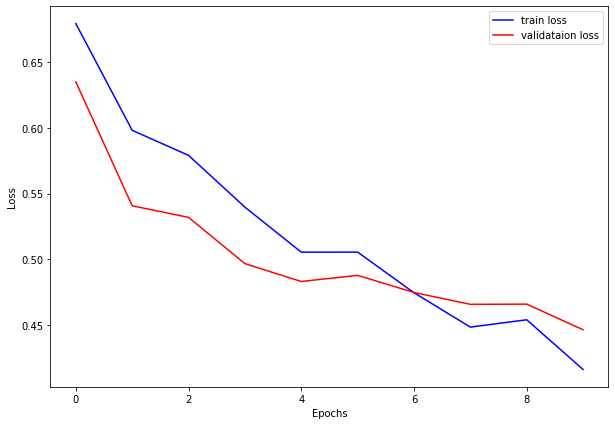

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='blue', linestyle='-', label='train loss')
plt.plot(val_losses, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# check = torch.rand(5,1,256,256)
# model = BoneAgePredictor();
# print(model.forward(check).size())

In [27]:
# check = pd.read_csv(dataset_path('boneage-training-dataset.csv'));
# print(check)
# print(check['boneage'][0])
# print(check['id'][1])
# check = Image.open(dataset_path('boneage-training-dataset',str(check['id'][1])+'.png')).resize((256,256))
# print(check)
# # check = transform(check)
# # print(check.size())
# # check = torch.from_numpy(np.array(check['boneage'][0]))
# # print(check)